In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
import math
from matplotlib import pyplot as plt
import random
from scipy.optimize import minimize
from qiskit.circuit.library import RZZGate
import networkx as nx
import pandas as pd
import seaborn as sns
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector

if random state $0$ encoded as $|0000>$, is provided, it returns state $|1100>$

if random state $1$ encoded as $|0001>$, is provided, it returns state $|0101>$

if random state $2$ encoded as $|0010>$, is provided, it returns state $|1010>$

if random state $3$ encoded as $|0011>$, is provided, it returns state $|0011>$

if any other random state is provided the code returns $|0000>$

In [2]:
N = 4
def initialization_state_0(circuit):
    return circuit

def initialization_state_1(circuit):
    circuit.x(0)
    return circuit

def initialization_state_2(circuit):
    circuit.x(1)
    return circuit

def initialization_state_3(circuit):
    circuit.x(0)
    circuit.x(1)
    return circuit

def random_variational_state(circuit):
    for qubit in circuit.qubits:
        circuit.rx(random_theta,qubit)
    return circuit

def rotational_unitary_layer(circuit, gamma, alpha):
    for qubit in circuit.qubits:
        circuit.ry(alpha,qubit)
    for qubit in circuit.qubits:
        circuit.rz(alpha,qubit)
    circuit.barrier()
   
    return circuit

def entanglement_layer(circuit):
    circuit.cx(0,1)
    circuit.cx(1,2)
    circuit.cx(2,3)
    circuit.cx(0,3)
    circuit.barrier()
    return circuit

def anasatz(params, init_state):
    gammas, alphas = create_params(params)
    q = QuantumRegister(N)
    c = ClassicalRegister(N)
    circuit = QuantumCircuit(q,c)
    #print(init_state)
    if init_state == 0:
        circuit = initialization_state_0(circuit)
    if init_state == 1:
        circuit = initialization_state_1(circuit)
    if init_state == 2:
        circuit = initialization_state_2(circuit)
    if init_state == 3:
        circuit = initialization_state_3(circuit)
    if init_state == "random variational state":
        circuit = random_variational_state(circuit)
        init_state = check_state(circuit)
    
    circuit.barrier()    
    l = int(len(gammas))
    for i in range(l):
        circuit = rotational_unitary_layer(circuit,gammas[i], alphas[i])
        circuit = entanglement_layer(circuit)  #Adding 4 layers to the circuit as we have defined depth as 4
    circuit = rotational_unitary_layer(circuit,gammas[i], alphas[i])    
    circuit.measure(circuit.qubits,c)
    
    simulator = BasicAer.get_backend('qasm_simulator')
    result = execute(circuit, simulator).result()
    counts = result.get_counts(circuit)
    results = counts.keys()
    new_res=[]
    for key in results:
        hold=[]
        for i in range(0,len(key)):
            hold.append(int(key[i]))
        for i in range(0,counts[key]):
            new_res.append(hold)
    return circuit,counts,new_res

def create_params(params):
    alphas = []
    gammas = []
    for i in range(int(len(params)/2)):
        gammas.append(params[2*i])
        alphas.append(params[2*i+1])
    return gammas , alphas
def first_guess_linear(n_layers, m1 = 0.5, m2 = 0.5):
    theta = np.zeros([2*n_layers])
    for i in range(2*n_layers):
        if i%2 == 0:
            theta[i] = m1*(i+1) / (2*n_layers)
        else:
            theta[i] = m2*(2*n_layers-i) / (2*n_layers)
    return (theta)
def get_maximum_z(counts):
    maximum = 0
    z = ''
    for key in counts.keys():
        if counts[key] > maximum:
            maximum = counts[key]
            z = key 
    return z
def array_of_key(key):
    hold=[]
    for i in range(0,len(key)):
        hold.append(int(key[i]))
    return hold
def check_state(circuit):
    
    q = QuantumRegister(4)
    c = ClassicalRegister(4)
    circuit = QuantumCircuit(q,c)
    circuit = initialization_state_3(circuit)
    
    sv = Statevector(circuit)
    
    q_0 = QuantumRegister(4)
    c_0 = ClassicalRegister(4)
    circuit_0 = QuantumCircuit(q,c)
    circuit_0 = initialization_state_0(circuit_0)
    sv_0 = Statevector(circuit_0)
    
    q_1 = QuantumRegister(4)
    c_1 = ClassicalRegister(4)
    circuit_1 = QuantumCircuit(q,c)
    circuit_0 = initialization_state_1(circuit_1)
    sv_1 = Statevector(circuit_1)
    
    q_2 = QuantumRegister(4)
    c_2 = ClassicalRegister(4)
    circuit_2 = QuantumCircuit(q,c)
    circuit_2 = initialization_state_2(circuit_2)
    sv_2 = Statevector(circuit_2)
    
    q_3 = QuantumRegister(4)
    c_3 = ClassicalRegister(4)
    circuit_3 = QuantumCircuit(q,c)
    circuit_3 = initialization_state_3(circuit_3)
    sv_3 = Statevector(circuit_3)
    
    in_state = "random variational state"

    if sv == sv_0:
        in_state = 0
    if sv == sv_1:
        in_state = 1
    if sv == sv_2:
        in_state = 2
    if sv == sv_3:
        in_state = 3
        
    return in_state

In [3]:
costs = []
def collect_costs(cost, costs):
    costs.append(cost)
def cost_function(params):
    init_state = in_state
    circuit,counts,result = anasatz(params, init_state)
    
    if init_state == 0:
        output = "1100"
    if init_state == 1:
        output = "0101"
    if init_state == 2:
        output = "1010"
    if init_state == 3:
        output = "0011"
    if init_state == "random variational state":
        output = "0000"
    
    
    out_bit = array_of_key(output)
    #print("Expected Output State:", out_bit)
    total_cost = 0
    for i in result:
        cost = 0
        for j in range(len(i)):
            cost = cost + 1000*((out_bit[j] - i[j])**2)
        total_cost = total_cost + cost
    
    total_cost = total_cost/1024
    
    collect_costs(total_cost, costs)
    return total_cost

In [4]:
def get_results(input_state):
    costs = []
    if input_state == 0:
        expout = "1100"
    if input_state == 1:
        expout = "0101"
    if input_state == 2:
        expout = "1010"
    if input_state == 3:
        expout = "0011"
    if input_state == "random variational state":
        expout = "0000"
    
    
    p = 7
   

    init_params = first_guess_linear(p, m1 = 0.5, m2 = 0.5)
    num_iters = 200
    print("optimization for depth :{}".format(p))
    method = 'COBYLA'
    backend="qasm"
    print("initial guess is:" +str(init_params))
    

    out = minimize(cost_function, x0=init_params, method="COBYLA", options={'maxiter':num_iters})
    print("\n")
    print(f'Out: {out}')
    circuit,counts,result = anasatz(out.x, input_state)

    expfrequency = 0
    for key in counts.keys():
        if key == expout:
            expfrequency = counts[key]
            
    z = get_maximum_z(counts)
    print("\n")
    #print("Initial state is:", in_state)
    print("Expected output is:", expout)
    print("Frequency of exepected output is:", expfrequency)
    print("Output with maximum frequency, z is:", z)
    print("Frequency of z is:", counts[z])
    
    return [circuit, counts]

Input State: 3
optimization for depth :7
initial guess is:[0.03571429 0.46428571 0.10714286 0.39285714 0.17857143 0.32142857
 0.25       0.25       0.32142857 0.17857143 0.39285714 0.10714286
 0.46428571 0.03571429]


Out:      fun: 1811.5234375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 110
  status: 1
 success: True
       x: array([0.03571837, 1.46431287, 0.10717492, 0.39289264, 1.17856377,
       0.32139184, 0.25002071, 0.25001412, 0.32141673, 0.17854006,
       0.39282777, 0.10711313, 0.46430797, 0.03575373])


Expected output is: 0011
Frequency of exepected output is: 140
Output with maximum frequency, z is: 0011
Frequency of z is: 140


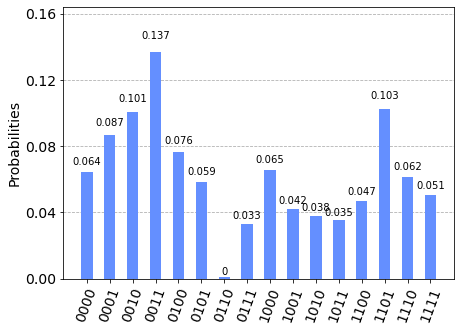

In [5]:
in_state = 3 #0011
print("Input State:", in_state)
result = get_results(in_state)
plot_histogram(result[1])

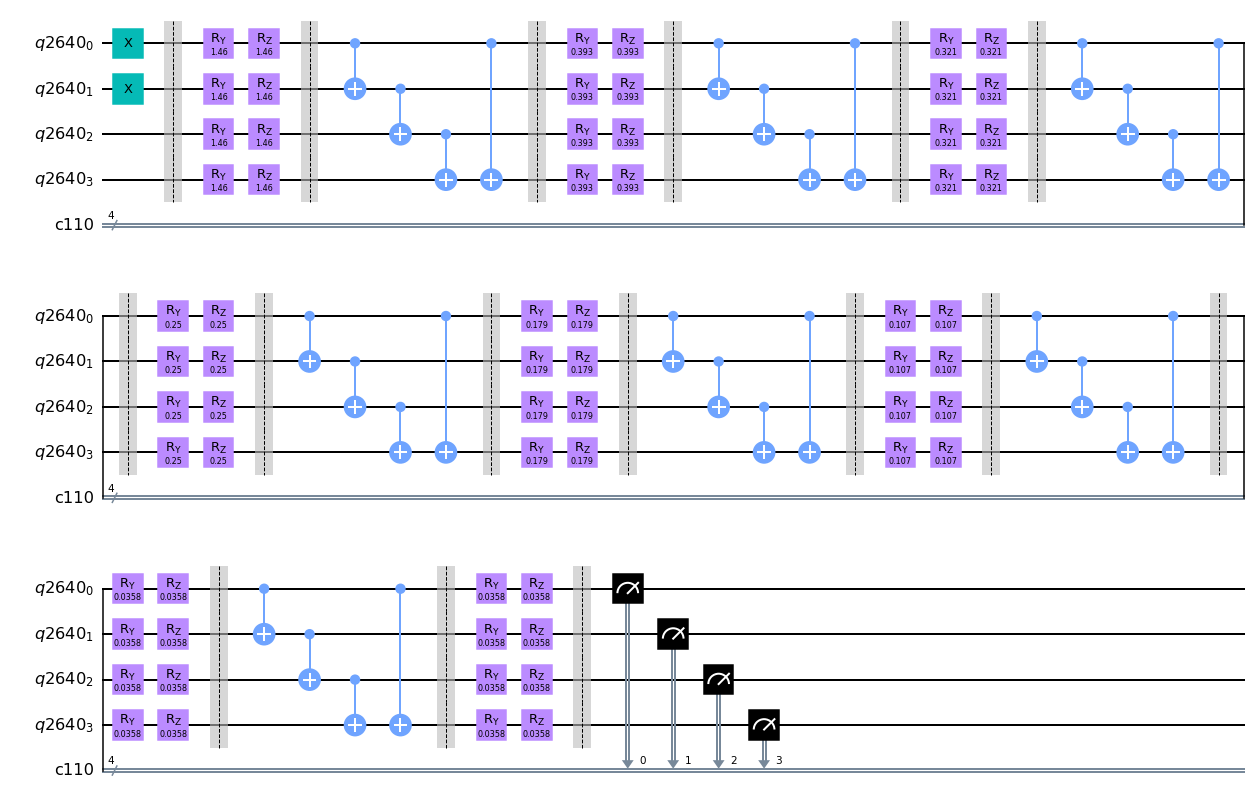

In [6]:
result[0].draw("mpl")

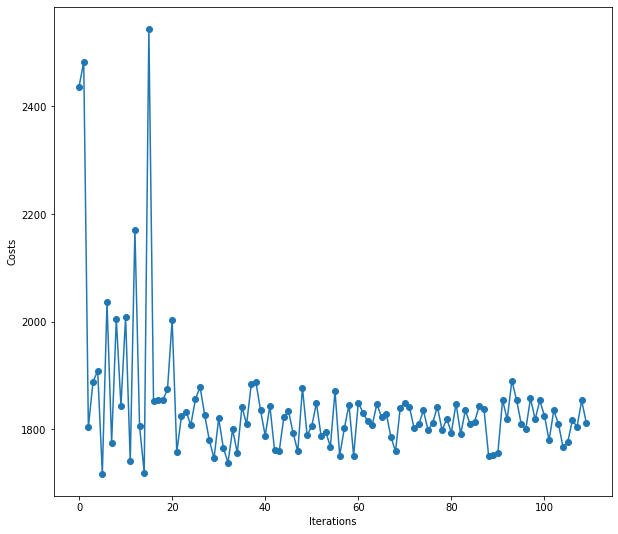

In [7]:
plt.figure(figsize=(10,9))
y = costs 
x = np.array(range(len(y)))
plt.plot(x,y, "-o")
plt.xlabel("Iterations")
plt.ylabel("Costs")
plt.show()
costs = []

Input State: 2
optimization for depth :7
initial guess is:[0.03571429 0.46428571 0.10714286 0.39285714 0.17857143 0.32142857
 0.25       0.25       0.32142857 0.17857143 0.39285714 0.10714286
 0.46428571 0.03571429]


Out:      fun: 1464.84375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 148
  status: 1
 success: True
       x: array([-0.04407485,  0.31742328,  0.04598872,  0.3441877 ,  0.61974622,
        0.33899011,  0.96754766,  0.37056308,  0.13960984,  0.02617534,
        0.93963065,  0.95910595,  1.4134374 ,  0.01411099])


Expected output is: 1010
Frequency of exepected output is: 183
Output with maximum frequency, z is: 1010
Frequency of z is: 183


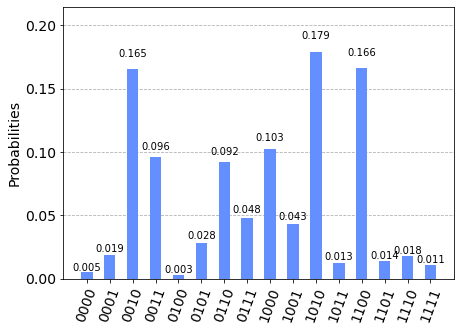

In [8]:
in_state = 2 #0010
print("Input State:", in_state)
result = get_results(in_state)
plot_histogram(result[1])

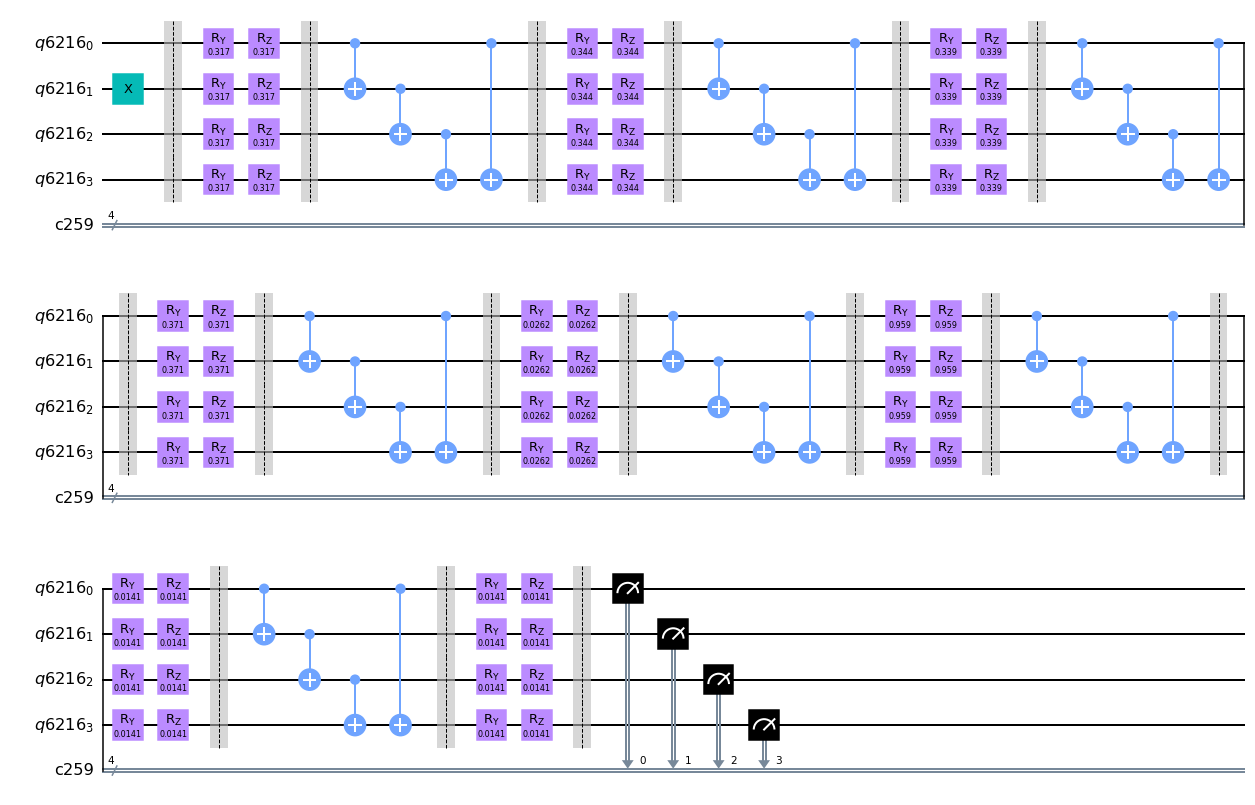

In [9]:
result[0].draw("mpl")

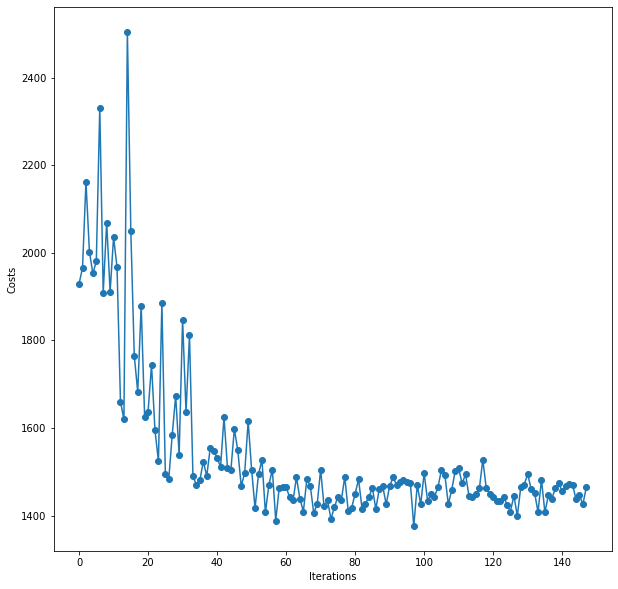

In [10]:
plt.figure(figsize=(10,10))
y = costs 
x = np.array(range(len(y)))
plt.plot(x,y, "-o")
plt.xlabel("Iterations")
plt.ylabel("Costs")
plt.show()
costs = []

Input State: 1
optimization for depth :7
initial guess is:[0.03571429 0.46428571 0.10714286 0.39285714 0.17857143 0.32142857
 0.25       0.25       0.32142857 0.17857143 0.39285714 0.10714286
 0.46428571 0.03571429]


Out:      fun: 678.7109375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 140
  status: 1
 success: True
       x: array([ 0.69413581,  1.80145481,  1.03754719,  1.05558412,  1.46466989,
        0.11355607, -0.03335406,  1.33005502,  1.0201558 ,  1.26675929,
        0.95023517,  1.53355287,  0.31791335, -0.05863132])


Expected output is: 0101
Frequency of exepected output is: 566
Output with maximum frequency, z is: 0101
Frequency of z is: 566


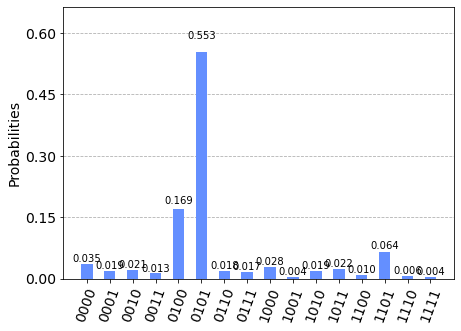

In [11]:
in_state = 1 #0001
print("Input State:", in_state)
result = get_results(in_state)
plot_histogram(result[1])

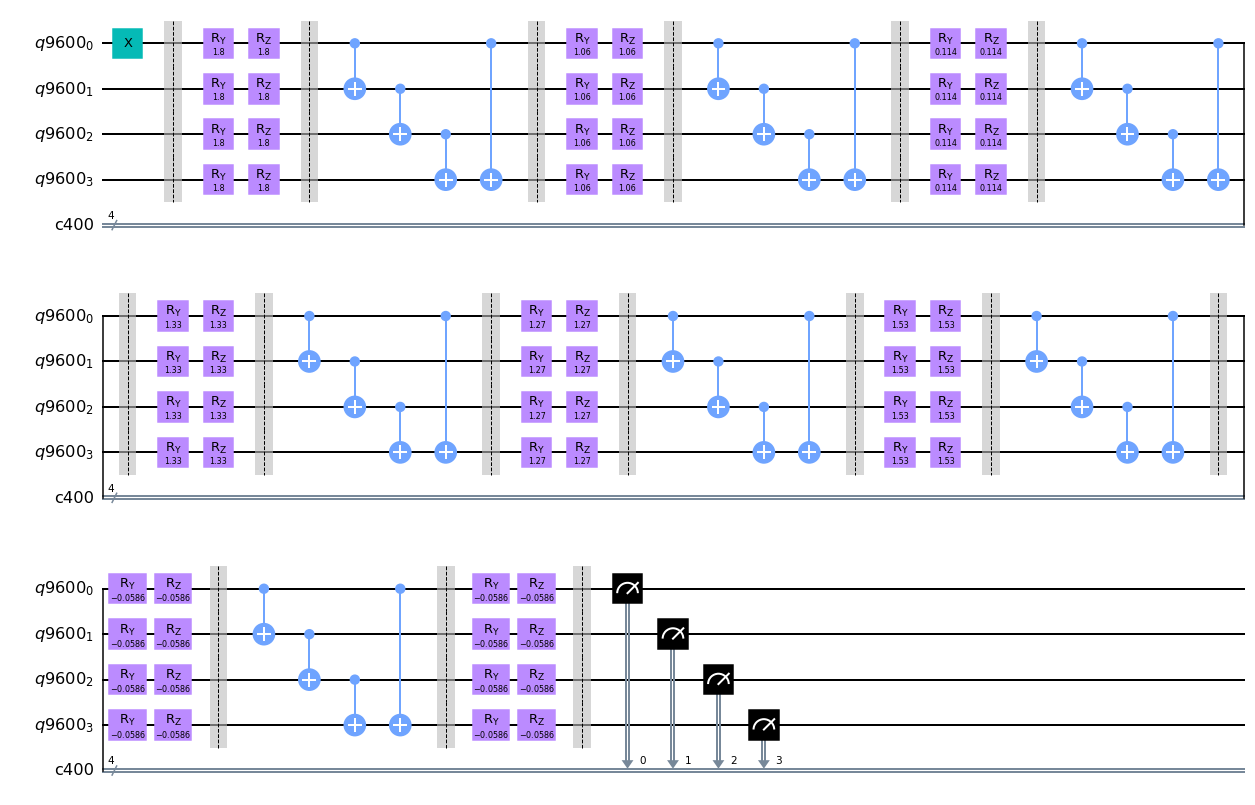

In [12]:
result[0].draw("mpl")

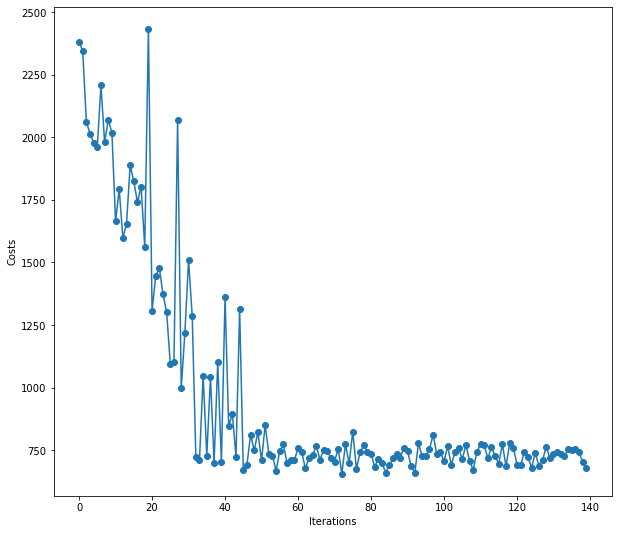

In [13]:
plt.figure(figsize=(10,9))
y = costs 
x = np.array(range(len(y)))
plt.plot(x,y, "-o")
plt.xlabel("Iterations")
plt.ylabel("Costs")
plt.show()
costs = []

Input State: 0
optimization for depth :7
initial guess is:[0.03571429 0.46428571 0.10714286 0.39285714 0.17857143 0.32142857
 0.25       0.25       0.32142857 0.17857143 0.39285714 0.10714286
 0.46428571 0.03571429]


Out:      fun: 1551.7578125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 120
  status: 1
 success: True
       x: array([0.03990277, 0.46103355, 1.10659305, 0.39219236, 0.17052554,
       0.57144618, 0.24651063, 0.25150446, 0.32035709, 0.16474819,
       0.39301142, 0.10263073, 0.46366775, 0.02587953])


Expected output is: 1100
Frequency of exepected output is: 98
Output with maximum frequency, z is: 0000
Frequency of z is: 336


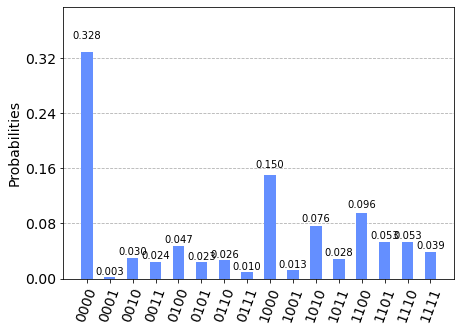

In [14]:
in_state = 0  #0000
print("Input State:", in_state)
result = get_results(in_state)
plot_histogram(result[1])

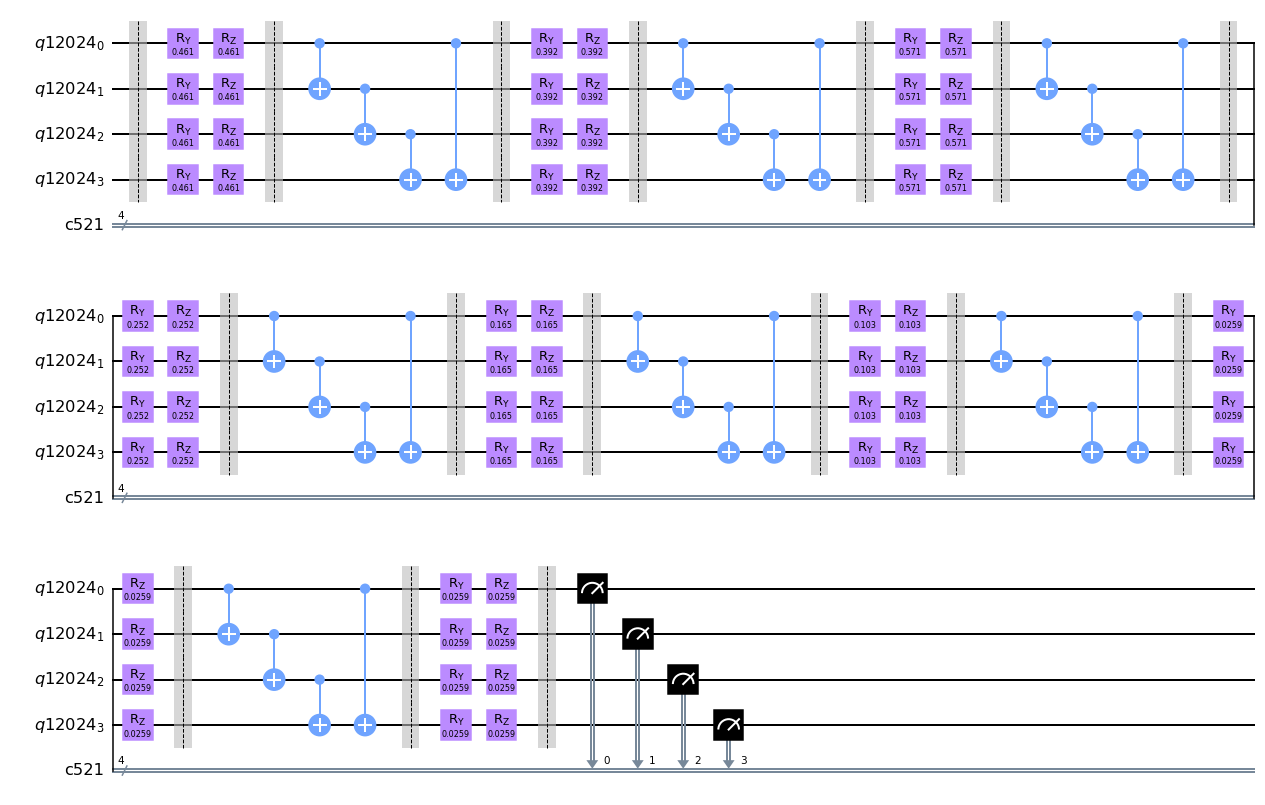

In [15]:
result[0].draw("mpl")

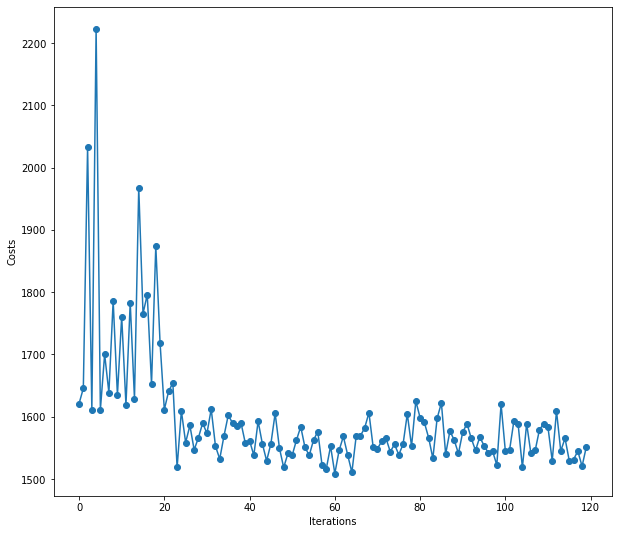

In [16]:
plt.figure(figsize=(10,9))
y = costs 
x = np.array(range(len(y)))
plt.plot(x,y, "-o")
plt.xlabel("Iterations")
plt.ylabel("Costs")
plt.show()
costs = []

Input State: random variational state
random theta: 2.8108117211042662
optimization for depth :7
initial guess is:[0.03571429 0.46428571 0.10714286 0.39285714 0.17857143 0.32142857
 0.25       0.25       0.32142857 0.17857143 0.39285714 0.10714286
 0.46428571 0.03571429]


Out:      fun: 1262.6953125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 139
  status: 1
 success: True
       x: array([ 0.37293019,  0.42973922, -0.05514704,  0.89939994, -0.32355757,
        0.51606038,  0.23860565,  1.43101401,  0.313354  ,  0.39435684,
        1.4174913 ,  0.41718796,  0.16902356, -0.35972357])


Expected output is: 0000
Frequency of exepected output is: 230
Output with maximum frequency, z is: 0000
Frequency of z is: 230


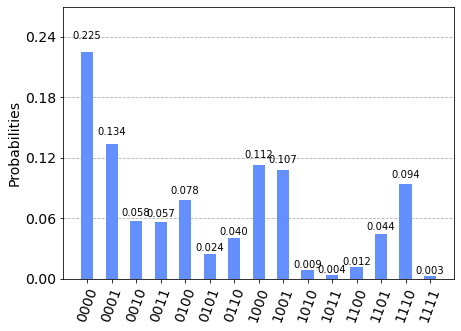

In [23]:
in_state = "random variational state"
print("Input State:", in_state)
random_theta = random.uniform(-np.pi, np.pi)
print("random theta:", random_theta)
result = get_results(in_state)
plot_histogram(result[1])

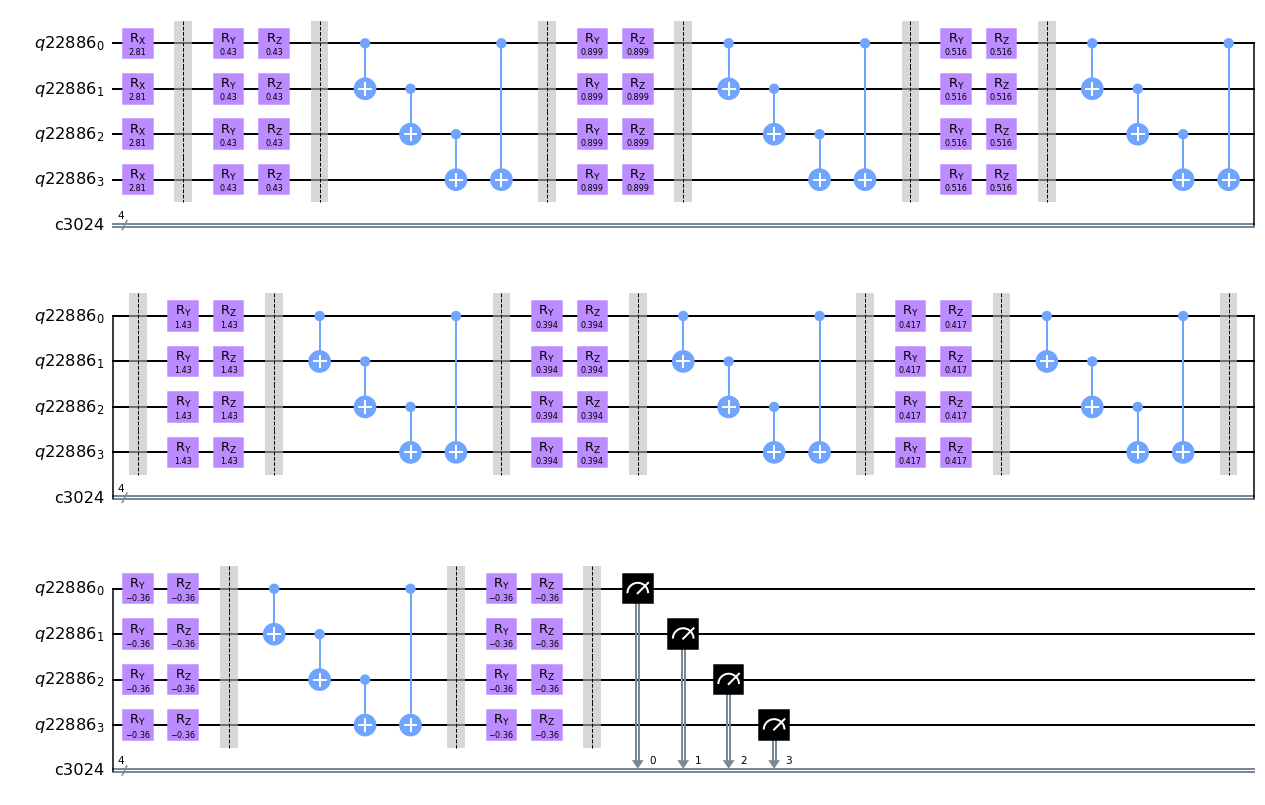

In [24]:
result[0].draw("mpl")

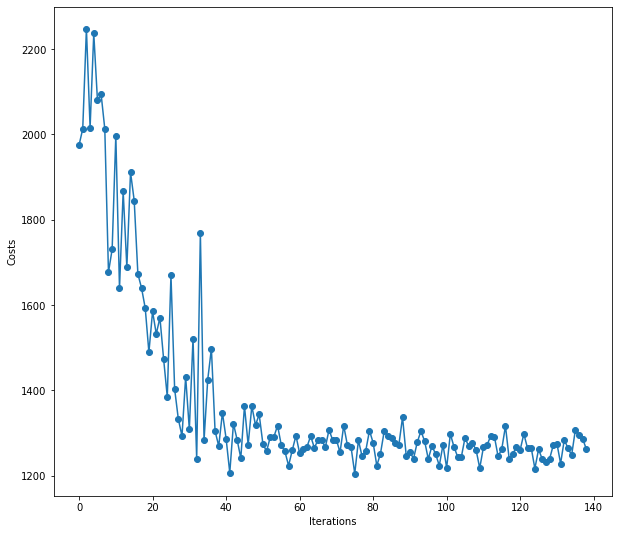

In [25]:
plt.figure(figsize=(10,9))
y = costs 
x = np.array(range(len(y)))
plt.plot(x,y, "-o")
plt.xlabel("Iterations")
plt.ylabel("Costs")
plt.show()
costs = []